<h3> Investigate Potential other periodic trends </h3>
There seems to be a potential other periodic trend in the data of approximately 15 years, especially visible before 1995. We wanted to statistically investigate this trend before including it in the poster. In order to do so, we calculated the autocorrelation of the inflow, performed a Fast-Fourier Transform and calculated a Lomb-Scargle periodogram with the monthly mean of the inflow.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle

In [2]:
#Load in Discharge Data
df_212270 = pd.read_csv('Data/Inflow/212270.csv', index_col=0, usecols= [1,2], parse_dates=True)
df_212270.index = df_212270.index.date
df_212270.rename(columns={'Flow Rate (ML/day)': '212270'}, inplace= True)

df_212260 = pd.read_csv('Data/Inflow/212260.csv', index_col=0, usecols= [1,2], parse_dates=True)
df_212260.index = df_212260.index.date
df_212260.rename(columns={'Flow Rate (ML/day)': '212260'}, inplace= True)

df_212250 = pd.read_csv('Data/Inflow/212250.csv',index_col=0, usecols= [1,2], parse_dates=True)
df_212250.index = df_212250.index.date
df_212250.rename(columns={'Flow Rate (ML/day)': '212250'}, inplace= True)

df_212280 = pd.read_csv('Data/Inflow/212280.csv', index_col=0, usecols= [1,2], parse_dates=True)
df_212280.index = df_212280.index.date
df_212280.rename(columns={'Flow Rate (ML/day)': '212280'}, inplace= True)


df_discharge = pd.concat([df_212250, df_212260, df_212270, df_212280], axis = 1, join='outer')

#df_discharge['Inflow Discharge (ML/day)'] = df_discharge['212250']+ df_discharge['212260']+ df_discharge['212270']+ df_discharge['212280']
df_discharge.index = pd.to_datetime(df_discharge.index)

df_discharge = df_discharge.resample('D').max()
#df_discharge.index = df_discharge.index.date

df_discharge

,212250,212260,212270,212280
1975-03-30,NaN,NaN,NaN,39.834
1975-03-31,NaN,NaN,NaN,NaN
1975-04-01,NaN,NaN,NaN,NaN
1975-04-02,307.758,NaN,NaN,NaN
1975-04-03,NaN,NaN,NaN,NaN
...,...,...,...,...
2024-09-14,188.645,170.526,352.426,17.448
2024-09-15,177.373,161.699,347.600,17.448
2024-09-16,175.794,152.053,334.657,15.582
2024-09-17,172.660,145.631,330.934,15.582


In [3]:
'''This function is used to fill the gaps in the discharge data by a rolling mean of the discharge of the 30 days prior'''
def fill_nan_with_rolling_mean(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, forcing errors to NaN
        nan_indices = df[df[col].isna()].index  # Get indices of NaN values
        for idx in nan_indices:
            # Select the last 7 valid (non-NaN) values based on the DateTime index
            prior_values = df[col].loc[:idx].dropna().rolling('30D').mean()
            if not prior_values.empty:
                df.at[idx, col] = prior_values.iloc[-1]  # Use last calculated mean
    return df

In [4]:
df_discharge_filled = fill_nan_with_rolling_mean(df_discharge)
#inflow = df_discharge_filled['Inflow Discharge (ML/day)'].resample('ME').mean()
#fig, ax = plt.subplots(figsize = (16,7))
#inflow.plot(ax = ax)
#ax.set_ylim(0, 500000)

In [6]:
df_discharge_filled.dropna(how = 'any',axis = 0, inplace=True)
df_discharge_filled_test = df_discharge_filled.copy()
df_discharge_filled_test['Q_sum [ML/d]'] = df_discharge_filled.sum(axis = 1)

df_discharge_filled_test

,212250,212260,212270,212280,Q_sum [ML/d]
1975-06-21,51993.494000,28879.4600,13548.371000,16332.240000,110753.565000
1975-06-22,33751.208000,28879.4600,775.573360,618.256688,64024.498049
1975-06-23,3146.529365,28879.4600,788.731627,636.177889,33450.898881
1975-06-24,3240.947370,28879.4600,802.199712,654.936954,33577.544035
1975-06-25,3338.506660,28879.4600,816.777841,674.312734,33709.057235
...,...,...,...,...,...
2024-09-14,188.645000,170.5260,352.426000,17.448000,729.045000
2024-09-15,177.373000,161.6990,347.600000,17.448000,704.120000
2024-09-16,175.794000,152.0530,334.657000,15.582000,678.086000
2024-09-17,172.660000,145.6310,330.934000,15.582000,664.807000


In [5]:
'''Use this code block if you are working from Github'''
#Load in Camel Precipitation Data
df_camel = pd.read_csv('Data/Prep_Camel_212260.csv')
df_camel['time'] = pd.to_datetime(df_camel['time'])
df_camel.set_index('time', inplace=True)
df_camel.rename(columns={'212260': 'RH'}, inplace=True)
df_camel = df_camel['RH']

#Load in Precipitation File from BOM
df = pd.read_csv('Data/Warrangamba_Prep.csv', usecols=[2,3,4,5])
df['time'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df.drop(['Day', 'Year', 'Month'], axis= 1, inplace = True)
df.dropna(axis= 0, inplace=True)
df.set_index('time', inplace=True)
df.rename(columns={'Rainfall amount (millimetres)':'RH'}, inplace=True)

df = df.loc['2019': '2024']
df = pd.concat([df_camel, df], axis = 0, join = 'outer')
df['RH'] = df['RH'] * ((75000**2)/1000)/1000 #Convert from mm to ML

df

,RH
time,
1900-01-01,8.260200
1900-01-02,0.000000
1900-01-03,3497.895844
1900-01-04,20.549813
1900-01-05,87405.289763
...,...
2024-01-28,0.000000
2024-01-29,0.000000
2024-01-30,0.000000


In [6]:
df_inflow = pd.concat([df_discharge_filled, df], axis = 1, join='inner')
df_inflow['Inflow Sum [ML/d]'] = df_inflow.sum(axis = 1)
inflow = df_inflow['Inflow Sum [ML/d]'].resample('ME').mean()

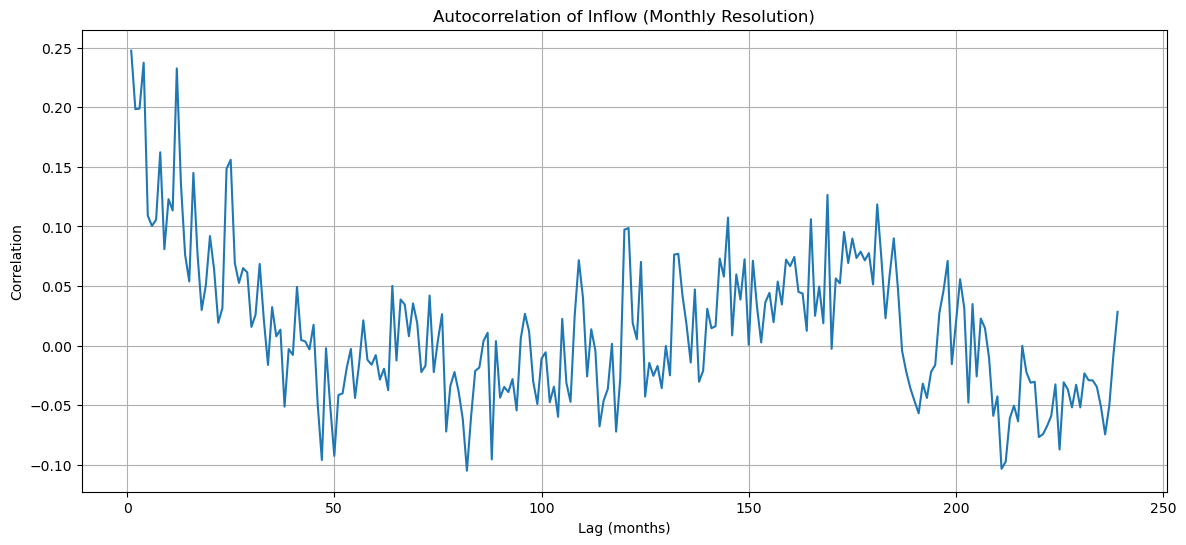

In [7]:
lags = np.arange(1,240) # check up to 20 years for monthly data
inflow_auto = np.zeros(len(lags))

for idx, lag in enumerate(lags):
     inflow_auto[idx] = inflow.autocorr(lag)

plt.figure(figsize=(14, 6))
plt.plot(lags, inflow_auto)
plt.title("Autocorrelation of Inflow (Monthly Resolution)")
plt.xlabel("Lag (months)")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()

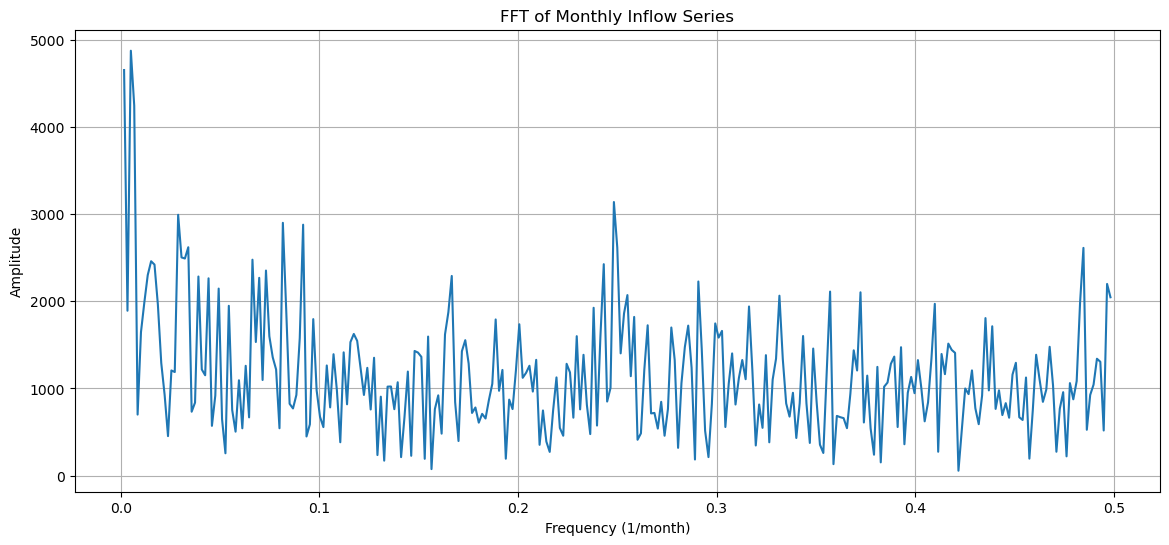

196.000000    4875.732907
588.000000    4654.078683
147.000000    4245.447761
4.027397      3139.367295
34.588235     2993.008121
12.250000     2900.732966
10.888889     2879.172033
29.400000     2620.229841
4.000000      2615.944148
2.063158      2613.067655
dtype: float64


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_36416\1281260269.py:19: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / xf
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_36416\1281260269.py:23: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / xf


In [8]:
'''Fourier Transform with no detrending of one year'''
from scipy.fft import fft, fftfreq
# --- FFT ---

N = len(inflow)
T = 1  # 1 point per month
yf = fft(inflow.values)
xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(14, 6))
plt.plot(xf[1:], 2.0/N * np.abs(yf[1:N//2]))
plt.title("FFT of Monthly Inflow Series")
plt.xlabel("Frequency (1/month)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Convert to periods (months per cycle)
periods = 1 / xf

# Compute amplitudes and periods
amplitudes = 2.0/N * np.abs(yf[0:N//2])
periods = 1 / xf

# Filter out invalid (inf or NaN) periods
valid = np.isfinite(periods) & (xf > 0)  # Remove inf, NaN, and freq = 0

# Create Series of dominant periods
dominant_periods = pd.Series(amplitudes[valid], index=periods[valid])

# Show top 10 peaks
print(dominant_periods.sort_values(ascending=False).head(10))


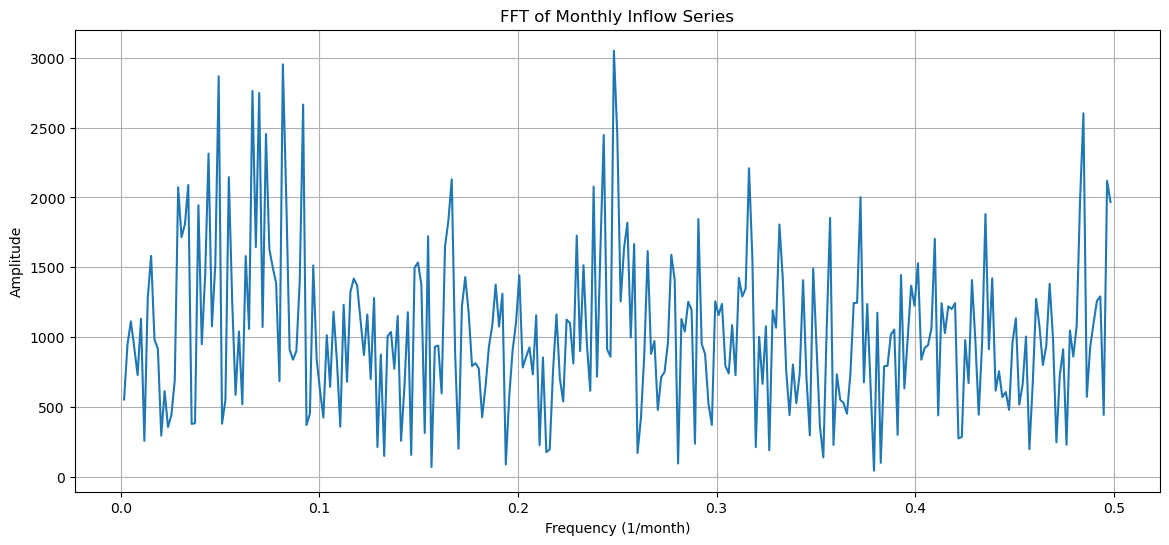

4.027397     3049.829097
12.250000    2952.456023
20.275862    2867.243363
15.076923    2762.188257
14.341463    2747.673090
10.888889    2664.245702
2.063158     2602.152898
13.674419    2454.252487
4.000000     2449.250572
4.111888     2446.765051
dtype: float64


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_36416\2415851038.py:23: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / xf
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_36416\2415851038.py:27: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / xf


In [9]:
'''Fourier Transform with detrending of one year'''
# Remove trend (optional but improves clarity)
inflow_detrended = inflow - inflow.rolling(window=12).mean()

# Fill NaNs if any
inflow_detrended = inflow_detrended.fillna(0)
# --- FFT ---

N = len(inflow_detrended)
T = 1  # 1 point per month
yf = fft(inflow_detrended.values)
xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(14, 6))
plt.plot(xf[1:], 2.0/N * np.abs(yf[1:N//2]))
plt.title("FFT of Monthly Inflow Series")
plt.xlabel("Frequency (1/month)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Convert to periods (months per cycle)
periods = 1 / xf

# Compute amplitudes and periods
amplitudes = 2.0/N * np.abs(yf[0:N//2])
periods = 1 / xf

# Filter out invalid (inf or NaN) periods
valid = np.isfinite(periods) & (xf > 0)  # Remove inf, NaN, and freq = 0

# Create Series of dominant periods
dominant_periods = pd.Series(amplitudes[valid], index=periods[valid])

# Show top 10 peaks
print(dominant_periods.sort_values(ascending=False).head(10))

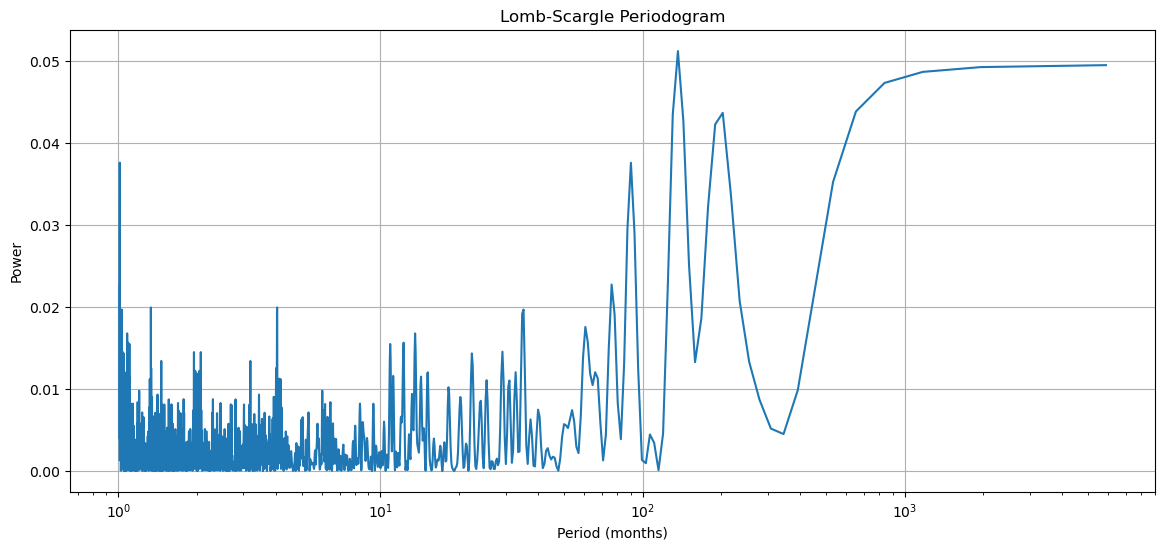

In [10]:
# Clean the data
flux = inflow.values
time = np.arange(len(inflow))

mask = np.isfinite(flux)
flux_clean = flux[mask]
time_clean = time[mask]

# Lomb-Scargle Periodogram
frequency, power = LombScargle(time_clean, flux_clean).autopower()
period = 1 / frequency

# Filter out weird values for plotting
valid = (period > 1.01) & np.isfinite(power)

plt.figure(figsize=(14,6))
plt.plot(period[valid], power[valid])
plt.xlabel("Period (months)")
plt.ylabel("Power")
plt.xscale('log')
plt.title("Lomb-Scargle Periodogram")
plt.grid(True)
plt.show()